In [1]:
# https://github.com/TomAugspurger/effective-pandas/blob/master/modern_2_method_chaining.ipynb

%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')

In [2]:
def read(fp):
    df = (pd.read_csv(fp)
            .rename(columns=str.lower)
            .pipe(extract_city_name)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time', 'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date']),
                    dest=lambda x: pd.Categorical(x['dest']),
                    origin=lambda x: pd.Categorical(x['origin']),
                    tail_num=lambda x: pd.Categorical(x['tail_num']),
                    unique_carrier=lambda x: pd.Categorical(x['unique_carrier']),
                    cancellation_code=lambda x: pd.Categorical(x['cancellation_code'])))
    return df

def extract_city_name(df):
    '''
    Chicago, IL -> Chicago for origin_city_name and dest_city_name
    '''
    cols = ['origin_city_name', 'dest_city_name']
    city = df[cols].apply(lambda x: x.str.extract("(.*), \w{2}", expand=False))
    df = df.copy()
    df[['origin_city_name', 'dest_city_name']] = city
    return df

def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes.

    2014-01-01,0914 -> 2014-01-01 09:14:00
    '''
    df = df.copy()
    def converter(col):
        timepart = (col.astype(str)
                       .str.replace('\.0$', '')  # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        return  pd.to_datetime(df['fl_date'] + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
        return datetime_part
    df[columns] = df[columns].apply(converter)
    return df

output = 'data/flights.h5'

location1 = r'C:\Users\adai\Documents\GitHub\PythonFiles\data\439091137_T_ONTIME.csv'

if not os.path.exists(output):
    df = read(location1)
    df.to_hdf(output, 'flights', format='table')
else:
    df = pd.read_hdf(output, 'flights', format='table')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450017 entries, 0 to 450016
Data columns (total 33 columns):
fl_date                  450017 non-null datetime64[ns]
unique_carrier           450017 non-null category
airline_id               450017 non-null int64
tail_num                 449378 non-null category
fl_num                   450017 non-null int64
origin_airport_id        450017 non-null int64
origin_airport_seq_id    450017 non-null int64
origin_city_market_id    450017 non-null int64
origin                   450017 non-null category
origin_city_name         450017 non-null object
dest_airport_id          450017 non-null int64
dest_airport_seq_id      450017 non-null int64
dest_city_market_id      450017 non-null int64
dest                     450017 non-null category
dest_city_name           450017 non-null object
crs_dep_time             450017 non-null datetime64[ns]
dep_time                 441445 non-null datetime64[ns]
dep_delay                441476 non-null float64


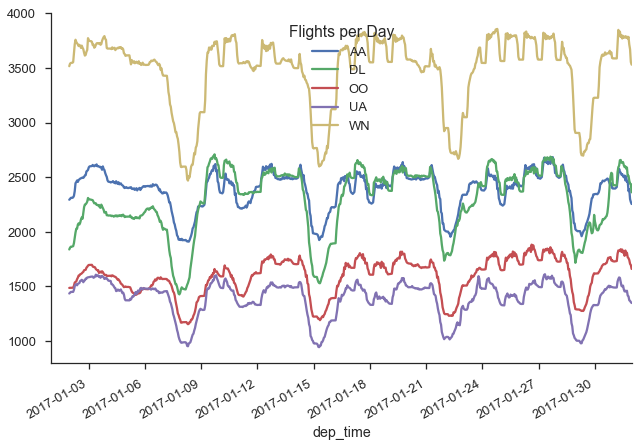

In [3]:
(df.dropna(subset=['dep_time', 'unique_carrier'])
     .loc[df['unique_carrier']
          .isin(df['unique_carrier'].value_counts().index[:5])]
     .set_index('dep_time')
     # TimeGrouper to resample & groupby at once
     .groupby(['unique_carrier', pd.TimeGrouper("H")])
     .fl_num.count()
     .unstack(0)
     .fillna(0)
     .rolling(24)
     .sum()
     .rename_axis("Flights per Day", axis=1)
     .plot()
)
sns.despine()

In [4]:
import statsmodels.api as sm

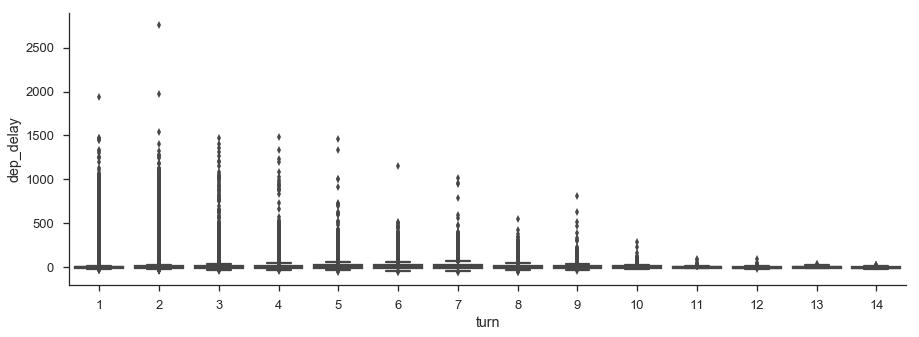

In [7]:
%config InlineBackend.figure_format = 'png'
flights = (df[['fl_date', 'tail_num', 'dep_time', 'dep_delay']]
           .dropna()
           .sort_values('dep_time')
           .assign(turn = lambda x:
                x.groupby(['fl_date', 'tail_num'])
                 .dep_time
                 .rank().astype(int)))

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='turn', y='dep_delay', data=flights, ax=ax)
sns.despine()

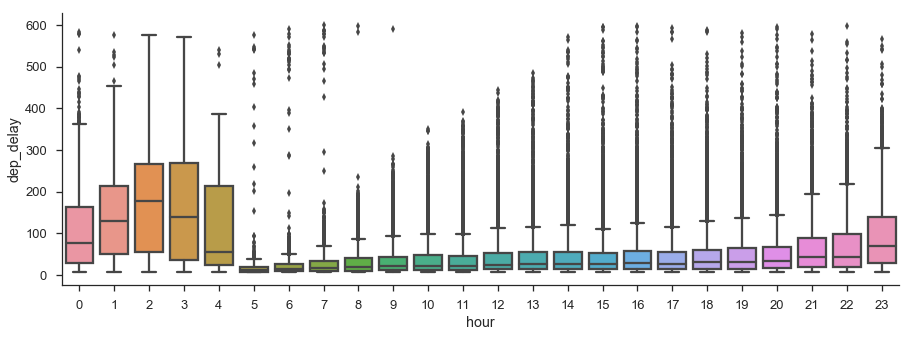

In [8]:
plt.figure(figsize=(15,5))
(df[['fl_date', 'tail_num', 'dep_time', 'dep_delay']]
    .dropna()
    .assign(hour=lambda x: x.dep_time.dt.hour)
    .query('5 < dep_delay < 600')
    .pipe((sns.boxplot, 'data'), 'hour', 'dep_delay'))
sns.despine()

In [12]:
planes = df.assign(year=df.fl_date.dt.year).groupby("tail_num")
delay = (planes.agg({"year": "count",
                    "arr_delay": "mean"})
                .rename(columns={"arr_delay": "delay",
                                "year": "count"})
                .query("count > 20 < 2000"))
delay.head()

,count,delay
tail_num,,
N001AA,49,6.040816
N002AA,34,-9.483871
N003AA,38,63.000000
N004AA,51,17.490196
N005AA,50,-0.795918
